<a href="https://colab.research.google.com/github/tevfikcagridural/student-success/blob/master/Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Engineering
In this notebook data will be prepared for mahinle learning model.

# Imports

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Load the data

In [51]:
attempts_features = pd.read_csv('https://raw.githubusercontent.com/tevfikcagridural/student-success/master/data/interim/attempts_features.csv')
attempts_features.head(2)

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,module_presentation_length,date_registration,date_unregistration,first_score,mean_score,last_score,min_weight_score,max_weight_score,submit_day_delta,num_banked,has_exam,num_of_assmnt,subpage_clicks,forumng_clicks,homepage_clicks,oucontent_clicks,ouwiki_clicks,quiz_clicks,resource_clicks,url_clicks
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,0,Pass,268,-159.0,NaN,78.0,82.0,82.0,78.0,85.0,9.0,0.0,0.0,5.0,32.0,193.0,138.0,553.0,0.0,0.0,13.0,5.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,0,Pass,268,-53.0,NaN,70.0,66.4,60.0,60.0,70.0,0.0,0.0,0.0,5.0,87.0,417.0,324.0,537.0,0.0,0.0,12.0,48.0


# Null Values and Useless Data Investigation

## Null Values

In [52]:
attempts_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   code_module                 32593 non-null  object 
 1   code_presentation           32593 non-null  object 
 2   id_student                  32593 non-null  int64  
 3   gender                      32593 non-null  object 
 4   region                      32593 non-null  object 
 5   highest_education           32593 non-null  object 
 6   imd_band                    31482 non-null  object 
 7   age_band                    32593 non-null  object 
 8   num_of_prev_attempts        32593 non-null  int64  
 9   studied_credits             32593 non-null  int64  
 10  disability                  32593 non-null  int64  
 11  final_result                32593 non-null  object 
 12  module_presentation_length  32593 non-null  int64  
 13  date_registration           325

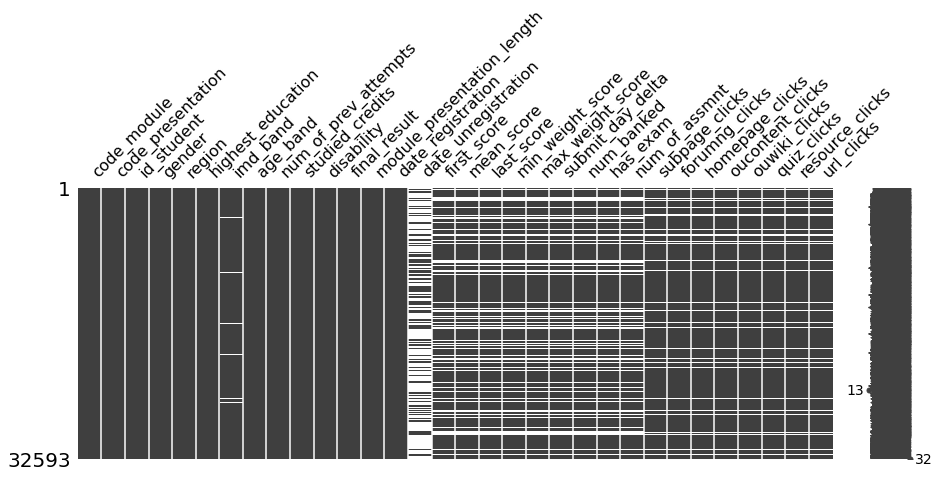

In [53]:
_ = msno.matrix(attempts_features, figsize=(15, 5))

While `date_unregistration` having the least number of non-null values obviously it has a negative relation with scores and VLE features. I assume that finished courses has no null for unregisteration. I'll remove this feature entirely. 
 
Score functions has the exact same number of non-null values. Especially `first_score` and `final_score`. Which is interesting because there would be students who leave the course after the first assignment. Which might mean if a student is unregistered after the first assignment their scores might set to 0 automatically.
  
Additionally, submission related features  having the same number of non-null with `num_banked`, `num_of _assmnt` and `has_exam` is interesting.

`imd_band` has the least number of null values. I'll check it first. While checking a categorical feature it's good to check if they have entries as `-`, `.`  etc. as they wouldn't count as null by `info` method

### IMD Band

In [54]:
obj_features = attempts_features.select_dtypes(include='object')

for col in obj_features.columns:
  print(col)
  print(attempts_features[col].unique(), '\n')

code_module
['AAA' 'BBB' 'CCC' 'DDD' 'EEE' 'FFF' 'GGG'] 

code_presentation
['2013J' '2014J' '2013B' '2014B'] 

gender
['M' 'F'] 

region
['East Anglian Region' 'Scotland' 'North Western Region'
 'South East Region' 'West Midlands Region' 'Wales' 'North Region'
 'South Region' 'Ireland' 'South West Region' 'East Midlands Region'
 'Yorkshire Region' 'London Region'] 

highest_education
['HE Qualification' 'A Level or Equivalent' 'Lower Than A Level'
 'Post Graduate Qualification' 'No Formal quals'] 

imd_band
['90-100%' '20-30%' '30-40%' '50-60%' '80-90%' '70-80%' nan '60-70%'
 '40-50%' '10-20' '0-10%'] 

age_band
['55<=' '35-55' '0-35'] 

final_result
['Pass' 'Withdrawn' 'Fail' 'Distinction'] 



Only `imd_band` has null values. I'll try to find if this is missing at completely random or not? This may be related with, `gender`, `region` and `highest_education`

In [55]:
imd_null = attempts_features[attempts_features['imd_band'].isna()]

cols = ['gender', 'region', 'highest_education']
for col in cols:
  print(col)
  print('Null values: \n', imd_null[col].unique(), '\n')
  print('All values: \n', attempts_features[col].unique(), '\n')

gender
Null values: 
 ['M' 'F'] 

All values: 
 ['M' 'F'] 

region
Null values: 
 ['North Region' 'Ireland' 'West Midlands Region' 'South Region'
 'South West Region' 'North Western Region' 'Yorkshire Region' 'Scotland'] 

All values: 
 ['East Anglian Region' 'Scotland' 'North Western Region'
 'South East Region' 'West Midlands Region' 'Wales' 'North Region'
 'South Region' 'Ireland' 'South West Region' 'East Midlands Region'
 'Yorkshire Region' 'London Region'] 

highest_education
Null values: 
 ['Post Graduate Qualification' 'HE Qualification' 'A Level or Equivalent'
 'Lower Than A Level' 'No Formal quals'] 

All values: 
 ['HE Qualification' 'A Level or Equivalent' 'Lower Than A Level'
 'Post Graduate Qualification' 'No Formal quals'] 



In [56]:
imd_null.shape

(1111, 32)

It doesn't seems like related with any of these. So I'll accept this as MCAR. But since there are 1111 entries I don't want to delete them. Instead I'll imput with mode. But, I split the train and test sets first, have the mode of the train set and impute it with both train and test set. With this way, I'll keep away any data leakage from test set to train set.

### Number of Assessments
This feature has the number of assessments student took during the module. NaN values most probably means no assessment taken 

In [57]:
# Check if there is any 0 entires
sum(attempts_features['num_of_assmnt'] == 0)

0

In [58]:
null_assmnt = attempts_features[attempts_features['num_of_assmnt'].isna()]
null_assmnt['final_result'].unique()

array(['Withdrawn', 'Fail', 'Pass'], dtype=object)

Pass result was unexpected

In [59]:
null_assmnt.query("final_result == 'Pass'")

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,module_presentation_length,date_registration,date_unregistration,first_score,mean_score,last_score,min_weight_score,max_weight_score,submit_day_delta,num_banked,has_exam,num_of_assmnt,subpage_clicks,forumng_clicks,homepage_clicks,oucontent_clicks,ouwiki_clicks,quiz_clicks,resource_clicks,url_clicks
645,AAA,2014J,1336190,M,London Region,HE Qualification,80-90%,55<=,0,60,0,Pass,269,-23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.0,32.0,235.0,576.0,0.0,0.0,11.0,47.0
12893,CCC,2014J,1777834,F,East Anglian Region,A Level or Equivalent,80-90%,35-55,0,60,0,Pass,269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20270,EEE,2013J,608472,M,North Western Region,Lower Than A Level,50-60%,0-35,0,60,0,Pass,268,-22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,15.0,161.0,433.0,83.0,200.0,9.0,29.0


I believe these are mislabeled as well. And being just 3 of them I'll remove

In [13]:
mislabeled_pass_idx = null_assmnt.query("final_result == 'Pass'").index

attempts_features = attempts_features.drop(labels=mislabeled_pass_idx, axis=0)

### Has Exam
This is a class related feture. Therefore, missing values can be imputed with other attempts from the same class

In [11]:
# Define if the class has exam or not
class_exam_status = (
    attempts_features
    .groupby(['code_module', 'code_presentation'])
    .max('has_exam')['has_exam']
)

# Add class exam status
attempts_features = attempts_features.join(class_exam_status,
                       on=['code_module', 'code_presentation'],
                       rsuffix='_class')

# Replace all has exam values with class exam status then drop the additional column
attempts_features['has_exam'] = attempts_features['has_exam_class']
attempts_features.drop('has_exam_class', axis=1, inplace=True)

### Date unregistration
`date_unregistration` feature has more null values than the actual ones. Therefore, I'll remove this feture entirely.

In [12]:
attempts_features = attempts_features.drop('date_unregistration', axis=1)

### Date Registeration
This feature had very little null values. I'll look if this missingness has any relation with other features.

In [16]:
date_register_null =  attempts_features[attempts_features['date_registration'].isna()]

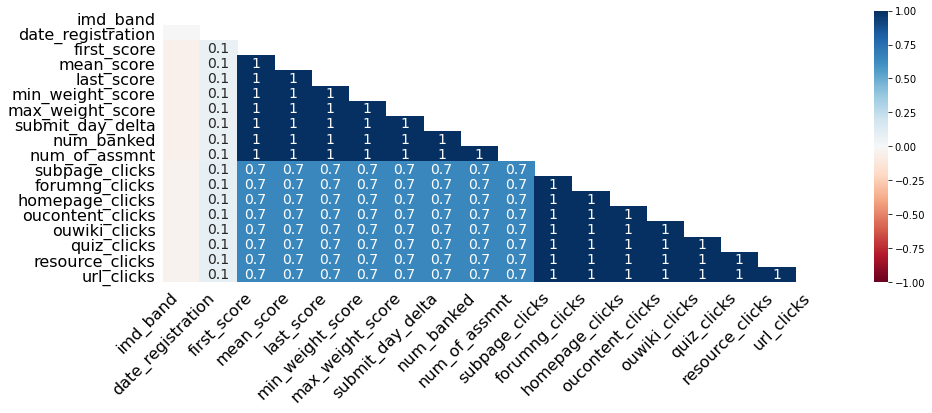

In [17]:
_ = msno.heatmap(attempts_features, figsize=(15,5))

So `date_registration` has no specific relation with a specific column. Having exactly same and very little relation with almost all other features has no meaning.

In [60]:
print(date_register_null['final_result'].unique())
print(date_register_null.shape[0])

['Fail' 'Withdrawn']
44


44 students who never registered and all of them ended being either fail or withdrawn. I'll remove these rows too

In [19]:
attempts_features = attempts_features[attempts_features['date_registration'].notna()]

### Score and VLE Features
I assume that other features like score and VLE has null values for withdrawn or fail attempts.


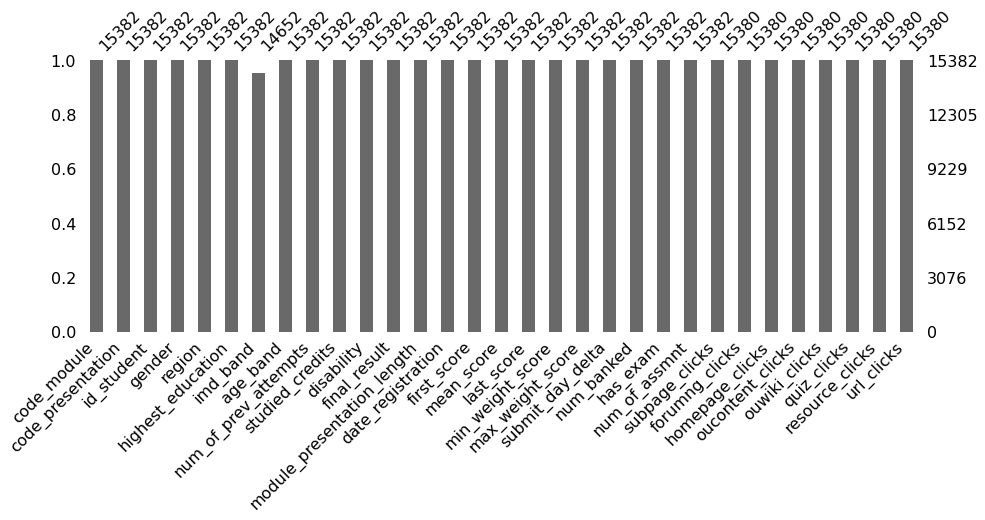

In [20]:
pass_and_dist = attempts_features[attempts_features['final_result'].isin(['Pass', 'Distinction'])]
_ = msno.bar(pass_and_dist, figsize=(15,5))

Yes, all null values for these features belong to withdrawn or failed attempts. Therefore I can impute them as 0. 

In [21]:
attempts_features = attempts_features.replace({
    'first_score': np.nan,
    'mean_score': np.nan,
    'last_score': np.nan,
    'min_weight_score': np.nan,
    'max_weight_score': np.nan,
    'subpage_clicks': np.nan,
    'forumng_clicks': np.nan,
    'homepage_clicks': np.nan,
    'oucontent_clicks': np.nan,
    'ouwiki_clicks': np.nan,
    'quiz_clicks': np.nan,
    'resource_clicks': np.nan,
    'url_clicks': np.nan
}, 0)

## Useless Data, Columns

### Code Module and Code Presentation
For this specific data this two columns together mean an actual class a student can take for a semester. Therefore I'll combine these two into one column to reduce the dimensions

In [23]:
# Create new column for both code module and presentation 
attempts_features['code_module_presentation'] =  attempts_features['code_module'] + attempts_features['code_presentation']

# Drop code module and presentation columns
attempts_features.drop(['code_module', 'code_presentation'], axis=1, inplace=True)

### Student Id
`id_student` is just a unique value for each student and has no use for a machine learning algorithm. So I'll drop it

In [24]:
attempts_features.drop('id_student', axis=1, inplace=True)

### Other Features

There left `submit_day_delta`, `num_banked` and `num_of_assmnt` and they are definetly not missing at random. They were showing the same pattern with score and VLE features and they belong to `withdrawn` and `fail` results. I cannot impute these missing values with any number because it would directly effect the behaviour of my model, I have to drop these columns.

In [22]:
attempts_features.drop(['submit_day_delta', 'num_banked', 'num_of_assmnt'],
                       axis=1, inplace=True)

# Train Test Split

In [25]:
X = attempts_features.drop(columns='final_result')
y = attempts_features['final_result']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [27]:
X_train.shape, X_test.shape

((24409, 25), (8137, 25))

In [28]:
y_train.shape, y_test.shape

((24409,), (8137,))

# Pipeline Build

 There are lots of non-numerical data which needs to be turned into numerical types in a proper way and the rest numerical features needs to be standardized. To be sure of Both X_train and X_test applied to same processes I'll combine whole process into a function.   

In [41]:
def X_preprocessor():
  """Builds the column tranformer for X
  returns column transformer to be used to transform X"""
  
  # Identify ordinal features to be used in Ordinal Encoder
  ordinal_features = ['age_band', 'highest_education', 'imd_band']

  # Identify nominal and binary features to be used in One Hot Encoder
  nominal_features = ['code_module_presentation', 'region', 'gender']

  # Identify numerical features to be scaled
  numerical_features = ['num_of_prev_attempts', 'studied_credits', 'disability',
                        'module_presentation_length', 'date_registration', 
                        'first_score','mean_score', 'last_score', 
                        'min_weight_score', 'max_weight_score','has_exam', 
                        'subpage_clicks', 'forumng_clicks', 'homepage_clicks',
                        'oucontent_clicks', 'ouwiki_clicks', 'quiz_clicks', 
                        'resource_clicks','url_clicks']


  # Make a piple for Ordinal features to be encoded and impute
  ordinal_procedure = make_pipeline(
      SimpleImputer(strategy='most_frequent'), # To impute imd_band NaN values 
      OrdinalEncoder())
  
  # Set final transformer for all features and their related transformations
  preprocessor = make_column_transformer((ordinal_procedure, ordinal_features),
                          (OneHotEncoder(drop='first'), nominal_features),
                          (StandardScaler(), numerical_features),
                          remainder='passthrough')


  return preprocessor
